In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as p
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import colors

from itertools import combinations
import scipy
from scipy.ndimage.filters import gaussian_filter1d
import sys
import os
import copy
atish_assay_path = 'fitness_assay_grantedits.py'
sys.path.append(os.path.dirname(os.path.expanduser(atish_assay_path)))
import fitness_assay_grantedits as atish

tools_path = '../code/tools.py'
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools

sns.set_style('white')
sns.set_style('ticks')
sns.set_color_codes()
from tools import mutant_colorset

In [ ]:
name = 'noF_DoubleBC_merged+flaskswapcorrected_041819' 

merged_data = p.read_csv(f'../data/BarcodeCounts_{name}_withBCinfo.csv')




In [4]:
old_conditions = {
                  '3':['3.1','3.2','3.3'],
                  '6':['6.1','6.2','6.3'],
                  '13':['13.1','13.2','13.3'],
                  '18':['18.1','18.2','18.3'],
                  '20':['20.1','20.2','20.3'],
                  '21':['21.1','21.2','21.3'],
                  '23':['23.1','23.2','23.3']
                 }

bigbatch_conditions = {
                        '1BB_M3':['A','B','C','D'],
                        '1BB_Baffle':['E','F'],
                        '1BB_1.4%Gluc' :['G','H'],
                        '1BB_1.8%Gluc' :['I','J'],
                        '1BB_0.2MNaCl' :['K','L'],
#                         '1BB_0.5MNaCl' :['M','N'],
#                         '1BB_0.2MNaCl' :['K'], 
                        '1BB_0.2MKCl' :['O'],
                        '1BB_0.5MKCl' :['P'],
#                         '1BB_8.5uMGdA' :['Q','R'],
#                         '1BB_17uMGdA' :['S','T'],
#                         '1BB_2ugFlu' :['U','V'],
#                         '1BB_0.5ugFlu' :['W','X'],
                        '1BB_1%Raf' :['Y','Z'],
                        '1BB_0.5%Raf' :['AA','BB'],
                        '1BB_1%Gly' :['CC','DD'],
#                         '1BB_1%EtOH' :['EE','FF'],
#                         '1BB_SucRaf' :['GG'],
                      }



conditions = {**old_conditions, **bigbatch_conditions}

just_reps = [rep for reps in conditions.values() for rep in reps]

In [ ]:
data = merged_data
data = data[~(data['barcode'].isin([7777777,9999999]))]
data = data.replace([np.inf, -np.inf], np.nan)
data = data.sort_values('barcode')

full_neutral_list = [17615,18486,42040,45014,58284,63611,73731,74185,80465,94896
,120600,125697,132511,134852,135750,190551,228237,238783,255561,298344
,308537,316954,317346,335717,411685,454359,469053] 

### from previous list but never has fitness above 3.5% (per gen) in any of 5000bc experiments
supergood_neutral = [17615, 24362, 42040, 71926, 72939, 73802, 80465, 109476, 113483, 
                     134852, 135750, 238783, 263665, 276406, 316954, 335717, 454359] 

### pulled from supergood list and spiked into 1BigBatch experiments
neutral_spikes = [17615,24362,42040,71926,73802,109476,113483,134852,263665,316954]

# neutrals = full_neutral_list
neutrals = list(np.unique(full_neutral_list+supergood_neutral+neutral_spikes))

neutrals = sorted(neutrals + data[data['gene'].isin(['NotSequenced'])])


neutral_locs = np.where(np.isin(data['barcode'].values,neutrals))[0]
genes = data['gene'].values



In [28]:
data

,13-0,13-0_pool,13-1-1,13-1-2,13-1-3,13-2-1,13-2-2,13-2-3,13-3-1,13-3-2,...,Z1,Z2,Z3,Z4,additional_muts,barcode,class,gene,ploidy,type
0,2.0,10.0,512.0,700.0,594.0,594.0,403.0,104.0,319.0,299.0,...,1103.0,281.0,15.0,128.0,TIP1-upstream_point_variant; YKR012C-upstream_...,53,Diploid,Diploid,Diploid,Diploid
1,2625.0,3914.0,43106.0,54385.0,42068.0,160273.0,107883.0,20536.0,399304.0,308884.0,...,108918.0,67856.0,3506.0,184186.0,"MIM1,tS-upstream_indel_variant; SEH1-missense_...",151,PKA,IRA1,Haploid,stop_gained
2,15.0,46.0,2909.0,2977.0,2776.0,2582.0,1640.0,442.0,1524.0,1028.0,...,914.0,119.0,6.0,111.0,NotSequenced,262,NotSequenced,NotSequenced,NotSequenced,NotSequenced
3,710.0,1187.0,36510.0,32361.0,30864.0,92924.0,59293.0,14493.0,149876.0,114393.0,...,29997.0,21563.0,935.0,26450.0,None,273,PKA,IRA1,Haploid,frameshift_variant
4,373.0,631.0,21956.0,23483.0,22294.0,46277.0,33707.0,7626.0,79897.0,57846.0,...,10486.0,3452.0,163.0,6759.0,NotSequenced,323,NotSequenced,NotSequenced,NotSequenced,NotSequenced
5,88.0,165.0,2745.0,4386.0,3120.0,7695.0,7096.0,1194.0,17769.0,18873.0,...,32531.0,26118.0,1540.0,36814.0,None,415,PKA,IRA1,Haploid,frameshift_variant
6,48.0,104.0,2335.0,3792.0,3057.0,5985.0,5549.0,1073.0,10823.0,10856.0,...,0.0,0.0,0.0,0.0,NotSequenced,499,NotSequenced,NotSequenced,NotSequenced,NotSequenced
7,0.0,3.0,64.0,57.0,65.0,81.0,27.0,7.0,34.0,23.0,...,464.0,122.0,9.0,81.0,NotSequenced,622,NotSequenced,NotSequenced,NotSequenced,NotSequenced
8,170.0,278.0,5462.0,7846.0,6551.0,15647.0,11789.0,1937.0,28198.0,27943.0,...,8717.0,10034.0,646.0,14755.0,RPL19A-upstream_point_variant,689,PKA,IRA1,Haploid,frameshift_variant
9,6.0,5.0,937.0,1094.0,910.0,936.0,601.0,141.0,581.0,397.0,...,676.0,204.0,5.0,96.0,NotSequenced,697,NotSequenced,NotSequenced,NotSequenced,NotSequenced


In [64]:
full_neutral_list = [17615,18486,42040,45014,58284,63611,73731,74185,80465,94896
,120600,125697,132511,134852,135750,190551,228237,238783,255561,298344
,308537,316954,317346,335717,411685,454359,469053] 

### from previous list but never has fitness above 3.5% (per gen) in any of 5000bc experiments
supergood_neutral = [17615, 24362, 42040, 71926, 72939, 73802, 80465, 109476, 113483, 
                     134852, 135750, 238783, 263665, 276406, 316954, 335717, 454359] 

### pulled from supergood list and spiked into 1BigBatch experiments
neutral_spikes = [17615,24362,42040,71926,73802,109476,113483,134852,263665,316954]

# neutrals = full_neutral_list
neutrals = sorted(list(np.unique(full_neutral_list+supergood_neutral+neutral_spikes)))

neutrals = [bc for bc in data['barcode'].values if bc in neutrals]

In [59]:
tools.downsample_single(np.asarray([t0_data,t1_data]).swapaxes(0,1),1e6)[neutral_locs,:]

array([[152.,  76.],
       [160.,  94.],
       [112.,  50.],
       [154.,  76.],
       [150.,  59.],
       [386., 185.],
       [123.,  59.],
       [359., 143.],
       [203.,  93.],
       [309., 154.],
       [  4.,   0.],
       [117.,  59.],
       [261., 103.]])

In [71]:
fitnesses = {}

for flask in ['A','B','C','D']:
    for time in range(4):
        for downcov in [1e5,1e6]:
            t0_data = data[f'{flask}{time}'].values
            t1_data = data[f'{flask}{time+1}'].values

            n_samples = 50
            down_samples = [tools.downsample_single(np.asarray([t0_data,t1_data]).swapaxes(0,1),downcov) for i in range(n_samples)]

            for sample in range(n_samples):
                timepoints = [time,time+1]

                answer = atish.inferFitness(data['barcode'].values,timepoints,{'rep1':down_samples[sample]},neutralBarcodes=neutrals,
                                                lowCoverageThresh=100,use_all_neutral=True,weightedMean=False)

                fitnesses[f'{flask}{time}_{int(downcov)}_{sample}'+'_fitness'] = answer['rep1']['aveFitness']

fitnesses['barcode'] = data['barcode'].values
resample_df = p.DataFrame(fitnesses)

# plt.savefig(f'Alltrajectories_old+1bb_swapscorrected_reshape.pdf',bbox_inches='tight')

2
neutral reads 1489.0 937.0
neutral reads 1489.0 935.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.52039002]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1451.0 960.0
neutral reads 1451.0 960.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.56448631]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1445.0 928.0
neutral reads 1445.0 928.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.46437238]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1497.0 995.0
neutral reads 1497.0 995.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.84090094]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1417.0 1000.0
neutral reads 1417.0 1000.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.41760845]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1447.0 946.0
neutral reads 1447.0 946.0
Multiplicati

/Users/grantkinsler/Documents/Stanford/Research/TheoryPaper/code/fitness_assay_grantedits.py:219: RuntimeWarning: divide by zero encountered in power
  zScores = zScores*np.power(expectedReads,-0.5)
/Users/grantkinsler/Documents/Stanford/Research/TheoryPaper/code/fitness_assay_grantedits.py:219: RuntimeWarning: invalid value encountered in multiply
  zScores = zScores*np.power(expectedReads,-0.5)
/Users/grantkinsler/Documents/Stanford/Research/TheoryPaper/code/fitness_assay_grantedits.py:386: RuntimeWarning: divide by zero encountered in log
  allTimeFitness = np.log(allReads[repName][:,1:]/totReads[1:])-np.log(allReads[repName][:,0:-1]/totReads[0:-1])
/Users/grantkinsler/Documents/Stanford/Research/TheoryPaper/code/fitness_assay_grantedits.py:386: RuntimeWarning: invalid value encountered in subtract
  allTimeFitness = np.log(allReads[repName][:,1:]/totReads[1:])-np.log(allReads[repName][:,0:-1]/totReads[0:-1])
/Users/grantkinsler/Documents/Stanford/Research/TheoryPaper/code/fitness_a

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [6.31503953]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 14756.0 9889.0
neutral reads 14756.0 9889.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [9.37493237]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 14649.0 9928.0
neutral reads 14649.0 9928.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [8.23671269]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 14837.0 9918.0
neutral reads 14837.0 9918.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.74013108]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 14899.0 9778.0
neutral reads 14899.0 9778.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.17943081]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 14854.0 9824.0
neutral reads 14854.0 9824.0
Multiplicative noise consistency checks

rep1  inc

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.49455597]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 964.0 489.0
neutral reads 964.0 489.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.50592077]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 942.0 524.0
neutral reads 942.0 524.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.92380547]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1034.0 504.0
neutral reads 1034.0 504.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.339595]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1021.0 476.0
neutral reads 1021.0 476.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.11747327]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1003.0 473.0
neutral reads 1003.0 473.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.83559692]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 557.0 209.0
neutral reads 557.0 208.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.03685702]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 507.0 208.0
neutral reads 507.0 208.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.20649263]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 497.0 195.0
neutral reads 497.0 195.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.25036639]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 529.0 201.0
neutral reads 529.0 201.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.86503812]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 483.0 214.0
neutral reads 483.0 214.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.67

kappas [3.345868]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4984.0 2159.0
neutral reads 4984.0 2159.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.96719571]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4960.0 2126.0
neutral reads 4960.0 2126.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.36695594]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4960.0 2148.0
neutral reads 4960.0 2148.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.74133757]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4990.0 2073.0
neutral reads 4990.0 2073.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.18746035]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5022.0 2125.0
neutral reads 5022.0 2125.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.05393297]
multNoise [0.1]
No clear inconsistencies



neutral reads 204.0 107.0
neutral reads 204.0 107.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.50277213]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 216.0 101.0
neutral reads 216.0 101.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.99981011]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 219.0 99.0
neutral reads 219.0 99.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.28271896]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 265.0 111.0
neutral reads 265.0 111.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.98885656]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 194.0 101.0
neutral reads 194.0 101.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.14664461]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 214.0 106.0
neutral reads 214.0 106.0
Multiplicative noise consisten

neutral reads 1733.0 1021.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [5.76082755]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1665.0 990.0
neutral reads 1665.0 990.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.11987684]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1699.0 1018.0
neutral reads 1699.0 1018.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.18279803]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1667.0 968.0
neutral reads 1667.0 968.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.98111512]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1611.0 973.0
neutral reads 1611.0 973.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.06346536]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1690.0 1032.0
neutral reads 1690.0 1030.0
Multiplicative noise consistency check

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [9.70424323]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 16439.0 10130.0
neutral reads 16439.0 10130.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [6.7790067]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 17053.0 10088.0
neutral reads 17053.0 10088.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [12.90799938]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 16563.0 10121.0
neutral reads 16563.0 10121.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [9.05337146]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 16683.0 10146.0
neutral reads 16683.0 10146.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [8.40525776]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 16653.0 10188.0
neutral reads 16653.0 10188.0
Multiplicative noise consistency checks


neutral reads 1005.0 443.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.4908656]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1043.0 478.0
neutral reads 1043.0 477.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.9264987]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1002.0 489.0
neutral reads 1002.0 487.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.52574349]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10165.0 4788.0
neutral reads 10165.0 4788.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.81994158]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10387.0 4728.0
neutral reads 10387.0 4728.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.86149907]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10080.0 4688.0
neutral reads 10080.0 4688.0
Multiplicative noise consistency 

2
neutral reads 488.0 198.0
neutral reads 488.0 198.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.90074264]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 471.0 198.0
neutral reads 471.0 198.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.04292866]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 461.0 201.0
neutral reads 461.0 201.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.23666012]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 450.0 184.0
neutral reads 450.0 184.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.44651554]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 495.0 176.0
neutral reads 495.0 176.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.7898401]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 518.0 180.0
neutral reads 518.0 180.0
Multiplicative noise consis

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.58409685]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4770.0 2009.0
neutral reads 4770.0 2009.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.97163236]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4806.0 1934.0
neutral reads 4806.0 1934.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.27853045]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4789.0 2024.0
neutral reads 4789.0 2024.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.60866246]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4861.0 2008.0
neutral reads 4861.0 2008.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.67355961]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 4782.0 1923.0
neutral reads 4782.0 1923.0
Multiplicative noise consistency checks

rep1  inconsistent 

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.56328967]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1984.0 1045.0
neutral reads 1984.0 1045.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.74576197]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 1984.0 1058.0
neutral reads 1984.0 1058.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.47793572]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2036.0 1028.0
neutral reads 2036.0 1028.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.39129452]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2026.0 1086.0
neutral reads 2026.0 1085.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.72914799]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2005.0 1037.0
neutral reads 2005.0 1037.0
Multiplicative noise consistency checks

rep1  inconsistent 

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.97651584]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 15756.0 9348.0
neutral reads 15756.0 9348.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.22356072]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 15870.0 9383.0
neutral reads 15870.0 9383.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.4243626]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 16041.0 9126.0
neutral reads 16041.0 9126.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.21331914]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 15786.0 9348.0
neutral reads 15786.0 9348.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.30547462]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 15962.0 9326.0
neutral reads 15962.0 9326.0
Multiplicative noise consistency checks

rep1  inco

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.72376826]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 983.0 564.0
neutral reads 983.0 564.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.45758033]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 937.0 536.0
neutral reads 937.0 536.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.06851575]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 888.0 538.0
neutral reads 888.0 538.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.54554729]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 940.0 535.0
neutral reads 940.0 534.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.28497146]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 970.0 510.0
neutral reads 970.0 510.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.22

2
neutral reads 9472.0 5384.0
neutral reads 9472.0 5384.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.91963209]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9401.0 5362.0
neutral reads 9401.0 5362.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.89444403]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9353.0 5388.0
neutral reads 9353.0 5388.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.78868006]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9497.0 5428.0
neutral reads 9497.0 5428.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [4.02751632]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9490.0 5381.0
neutral reads 9490.0 5381.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.23507334]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 9339.0 5440.0
neutral reads 9339.0 5440.0
Mu

2
neutral reads 542.0 297.0
neutral reads 542.0 297.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.01469774]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 553.0 266.0
neutral reads 553.0 266.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.90219506]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 533.0 266.0
neutral reads 533.0 266.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.45973028]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 530.0 279.0
neutral reads 530.0 279.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.04305567]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 556.0 274.0
neutral reads 556.0 274.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.23663421]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 535.0 283.0
neutral reads 535.0 283.0
Multiplicative noise consi

2
neutral reads 5402.0 2745.0
neutral reads 5402.0 2745.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.74239657]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5306.0 2734.0
neutral reads 5306.0 2734.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.1236949]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5475.0 2734.0
neutral reads 5475.0 2734.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.80242122]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5407.0 2835.0
neutral reads 5407.0 2835.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.77909153]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5249.0 2674.0
neutral reads 5249.0 2674.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [3.19497088]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5516.0 2725.0
neutral reads 5516.0 2725.0
Mul

2
neutral reads 262.0 110.0
neutral reads 262.0 110.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.74564717]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 287.0 130.0
neutral reads 287.0 130.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.90824995]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 269.0 135.0
neutral reads 269.0 135.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.09703513]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 253.0 123.0
neutral reads 253.0 123.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.47580768]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 278.0 125.0
neutral reads 278.0 125.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.71678737]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 265.0 140.0
neutral reads 265.0 140.0
Multiplicative noise consi

neutral reads 2606.0 1226.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.72389018]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2703.0 1176.0
neutral reads 2703.0 1176.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.5923617]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2684.0 1226.0
neutral reads 2684.0 1226.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.17117579]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2724.0 1223.0
neutral reads 2724.0 1223.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.74477011]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2788.0 1270.0
neutral reads 2788.0 1270.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.96327002]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2692.0 1194.0
neutral reads 2692.0 1194.0
Multiplicative noise consistency 

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [12.82260283]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 20863.0 10487.0
neutral reads 20863.0 10487.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [10.74168906]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 21085.0 10642.0
neutral reads 21085.0 10642.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [10.59825554]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 20856.0 10651.0
neutral reads 20856.0 10651.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [13.22548435]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 20879.0 10546.0
neutral reads 20879.0 10546.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [12.23230711]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 20746.0 10526.0
neutral reads 20746.0 10526.0
Multiplicative noise consistency ch

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.87715586]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10606.0 5328.0
neutral reads 10606.0 5328.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.80066556]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10429.0 5336.0
neutral reads 10429.0 5336.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.7493923]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10478.0 5217.0
neutral reads 10478.0 5217.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.79255315]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10316.0 5315.0
neutral reads 10316.0 5315.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.71185838]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 10776.0 5176.0
neutral reads 10776.0 5176.0
Multiplicative noise consistency checks

rep1  inco

2
neutral reads 578.0 246.0
neutral reads 578.0 246.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.67282064]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 520.0 240.0
neutral reads 520.0 240.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.23144188]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 517.0 227.0
neutral reads 517.0 227.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.80795773]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 525.0 228.0
neutral reads 525.0 228.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.47279473]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 527.0 268.0
neutral reads 507.0 252.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.19870447]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 526.0 249.0
neutral reads 526.0 249.0
Multiplicative noise consi

2
neutral reads 5256.0 2559.0
neutral reads 5256.0 2559.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.67674879]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5238.0 2479.0
neutral reads 5238.0 2479.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.82916687]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5293.0 2555.0
neutral reads 5293.0 2555.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.06879027]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5303.0 2543.0
neutral reads 5303.0 2543.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.35736256]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5319.0 2557.0
neutral reads 5319.0 2557.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.05998215]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 5288.0 2521.0
neutral reads 5288.0 2521.0
Mu

2
neutral reads 253.0 146.0
neutral reads 253.0 146.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.62021979]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 228.0 101.0
neutral reads 228.0 101.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.42934806]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 225.0 109.0
neutral reads 225.0 109.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.12584537]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 219.0 109.0
neutral reads 219.0 109.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.22764452]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 276.0 131.0
neutral reads 276.0 131.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.86076118]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 266.0 125.0
neutral reads 266.0 125.0
Multiplicative noise consi

Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.19354326]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2478.0 1162.0
neutral reads 2478.0 1162.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [2.18781153]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2489.0 1200.0
neutral reads 2489.0 1200.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.15454588]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2561.0 1155.0
neutral reads 2561.0 1155.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [0.9689455]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2493.0 1164.0
neutral reads 2493.0 1164.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [1.50398614]
multNoise [0.1]
No clear inconsistencies

2
neutral reads 2493.0 1159.0
neutral reads 2493.0 1159.0
Multiplicative noise consistency checks

rep1  inconsistent t

In [84]:
resample_df.to_csv('../data/Fitness_Merged_1BB_M3_Resampled.csv',index=False)

In [85]:
resample_df

,A0_1000000_0_fitness,A0_1000000_10_fitness,A0_1000000_11_fitness,A0_1000000_12_fitness,A0_1000000_13_fitness,A0_1000000_14_fitness,A0_1000000_15_fitness,A0_1000000_16_fitness,A0_1000000_17_fitness,A0_1000000_18_fitness,...,D3_100000_47_fitness,D3_100000_48_fitness,D3_100000_49_fitness,D3_100000_4_fitness,D3_100000_5_fitness,D3_100000_6_fitness,D3_100000_7_fitness,D3_100000_8_fitness,D3_100000_9_fitness,barcode
0,0.171060,0.137874,0.119903,0.236192,0.128928,0.180380,0.161187,0.143935,0.139047,0.165028,...,0.623528,0.591364,-0.146183,0.302002,0.324596,0.499835,0.454740,0.388867,0.475223,53
1,0.497150,0.496052,0.506889,0.504954,0.513485,0.525000,0.503662,0.501352,0.495190,0.491711,...,1.177642,1.353429,0.989806,0.896472,1.184036,1.083511,1.049252,0.968494,1.182287,151
2,0.093574,0.182473,0.142764,0.138918,0.080590,0.126864,0.108638,0.183963,0.139534,0.130080,...,0.430533,0.545227,0.185649,-0.000809,0.549292,0.002432,0.764741,0.399576,0.357674,262
3,0.505782,0.517499,0.533207,0.521518,0.515069,0.534172,0.506088,0.501291,0.507355,0.483664,...,1.000816,1.142036,0.794590,0.715377,0.936119,0.862988,0.816933,0.723995,0.993493,273
4,0.622275,0.611400,0.634908,0.625883,0.643156,0.641196,0.627761,0.632684,0.590504,0.603471,...,0.920486,1.094184,0.637669,0.529965,0.911204,0.675751,0.793408,0.673925,0.810903,323
5,0.832679,0.804443,0.822640,0.824962,0.831803,0.840618,0.821445,0.821790,0.820033,0.831918,...,1.070940,1.189358,0.826718,0.682277,1.064383,0.986098,0.899941,0.726921,1.005340,415
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,499
7,0.084242,0.142617,0.248541,0.079992,0.151938,0.176658,0.169952,0.116778,0.137453,0.154668,...,0.689023,0.805625,0.635157,0.010947,0.804073,0.055778,0.550356,0.266977,0.522851,622
8,0.705860,0.672095,0.698652,0.665611,0.647962,0.652935,0.634491,0.629581,0.642181,0.631837,...,1.125820,1.387402,0.947007,0.808224,1.172586,1.058050,1.056773,0.892161,1.062298,689
9,0.222878,0.291194,0.299029,0.290708,0.274991,0.310632,0.223363,0.197406,0.238028,0.247747,...,0.449886,0.422857,-0.161931,0.233009,0.445613,0.184754,0.556817,0.297749,0.508905,697


In [134]:
fitnesses2 = []

n_samples = 2
down_samples = [tools.downsample_single(np.asarray([t0_data,t1_data]).swapaxes(0,1),1e6) for i in range(n_samples)]

for sample in range(n_samples):
    
    log_freqs = [down_samples[sample][:,t]/np.nansum(down_samples[sample][:,t]) for t in range(2)]
    log_freqs = np.log(np.asarray(log_freqs))
    
    these_fitnesses = np.diff(log_freqs,axis=0)[0]
    
    these_fitnesses[these_fitnesses == np.inf] = np.nan
    these_fitnesses[these_fitnesses == -np.inf] = np.nan
        
    mean_neutral_deviation = np.nanmean(these_fitnesses[neutral_locs],axis=0)
#         print(condition,t,mean_neutral_deviation)
    these_fitnesses = these_fitnesses - mean_neutral_deviation

    fitnesses2.append(these_fitnesses)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/lib/function_base.py:1946: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


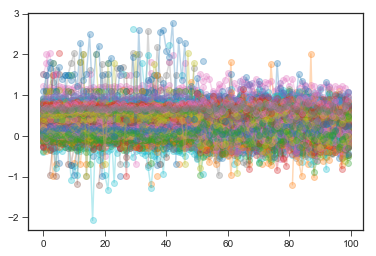

In [83]:
flask = 'A'
time = '0'
coverage = int(1e5)
for bc in range(len(resample_df.index)):
    plt.plot(resample_df[[col for col in resample_df.columns if f'{flask}{time}_{coverage}' in col]].values[bc,:],'-o',alpha=0.3)

In [74]:
1e6

1000000.0

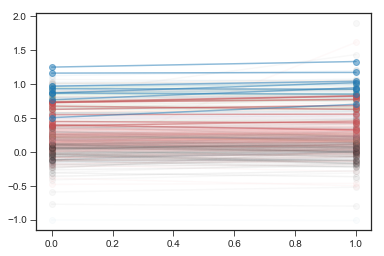

In [142]:
swapped2 = np.asarray(fitnesses2).swapaxes(0,1)
for bc in range(swapped2.shape[0]):
    if data['barcode'].values[bc] > 9000100:
        plt.plot(swapped2[bc],'o-',color=mutant_colorset[genes[bc]],alpha=0.5)
    elif data['barcode'].values[bc] > 9000000:
        plt.plot(swapped2[bc],'o-',color='r',alpha=0.5)
    else:
        plt.plot(swapped2[bc],'o-',color=mutant_colorset[genes[bc]],alpha=0.05)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice.
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Degrees of freedom <= 0 for slice.
  import sys
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Degrees of freedom <= 0 for slice.
  


Text(0,0.5,'Variance Across 2 Resamples')

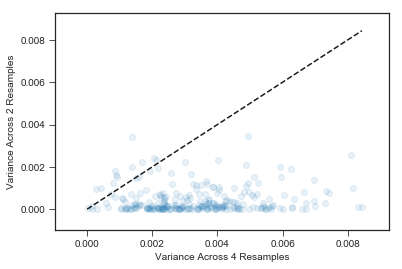

In [140]:
reads = down_samples[0]

coverage_cutoff = 1000
cutoff_indices = np.where(np.all(reads>coverage_cutoff,axis=1))[0]

plt.scatter(np.nanvar(swapped,axis=1)[cutoff_indices],np.nanvar(swapped2,axis=1)[cutoff_indices],alpha=0.1)
bigmin = min([min(np.nanvar(swapped,axis=1)[cutoff_indices]),min(np.nanvar(swapped2,axis=1)[cutoff_indices])])
bigmax = max([max(np.nanvar(swapped,axis=1)[cutoff_indices]),max(np.nanvar(swapped2,axis=1)[cutoff_indices])])
plt.plot([bigmin,bigmax],[bigmin,bigmax],'k--')
plt.xlim(-0.001,bigmax*1.1)
plt.ylim(-0.001,bigmax*1.1)
plt.xlabel('Variance Across 4 Resamples')
plt.ylabel('Variance Across 2 Resamples')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Degrees of freedom <= 0 for slice.
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


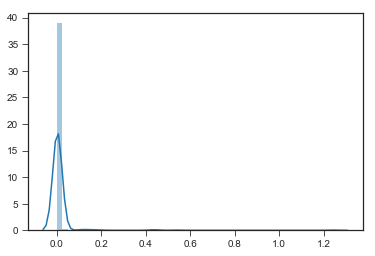

In [120]:
def sumPairs(arr, n): 
  
    # final result 
    sum = 0
    for i in range(n - 1, -1, -1): 
        sum += i*arr[i] - (n-1-i) * arr[i] 
    return sum